In [27]:
GUROBI_TIME_LIMIT = 3600

# Project 2: Index Replication

| Name | EID |
| --- | --- |
| Divyansh Karki | dk27856 |
| Jared Hurwit | jbh3358 |
| Brandt Green | bwg537 |

### Assumptions:
* For the two data files, we assume that the first column loaded will be the date column, the second column, will be the index prices, and the rest of the columns will be stock process.
* There are the same amount of stocks in both the 2019 & 2020 data files.

In [28]:
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns; sns.set_theme()
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Extract and format data

Read in the data:

We assume the 2019 data is placed in a csv file named 'stocks2019.csv' and the 2020 data is placed in a csv file named 'stocks2020.csv'. Both should be placed in the same folder as this notebook.

In [29]:
data_2019 = pd.read_csv('stocks2019.csv')
data_2020 = pd.read_csv('stocks2020.csv')

Converting the data into desired formats:

Here, we just create a function that will take our raw data dataframes, extracted above, and convert it into new dataframes that are cleaned up a bit. We convert the date object into a pandas datetime data type and move it to the dataframes index. We then separate each of the raw data dataframes into two pieces: One dataframe containing the index prices, and another containing the stock prices. We now have four dataframes of price information for the index and stocks, broken out by year.

In [30]:
def convert_raw_data_to_dfs(df:pd.DataFrame):
    """Send in a raw data df and this function will return two datframes. The first is a dataframe of the index prices, and the second will only have the stocks."""
    df_cleaned = df.copy()
    df_cleaned.index = pd.to_datetime(df_cleaned.iloc[:,0])
    df_cleaned.index.name = 'date'
    df_cleaned = df_cleaned.iloc[:,1:] # Exclude the date column since it is now in the index.

    df_index = df_cleaned.iloc[:,:1] # Index will now be in the first column
    df_stocks = df_cleaned.iloc[:,1:] # The stocks are everyting else.

    return df_index, df_stocks

df_index_19, df_stocks_19 =  convert_raw_data_to_dfs(data_2019)
df_index_20, df_stock_20 = convert_raw_data_to_dfs(data_2020)

But actually, we don't care all that much about what the prices were, and what we really want is to have dataframes containing the daily return information. Below, we convert our price dataframes into dataframes containing the returns:

In [31]:
def calculate_returns(df:pd.DataFrame) -> pd.DataFrame:
    return df.pct_change().dropna()

index_returns_19, index_returns_20 = calculate_returns(df_index_19), calculate_returns(df_index_20)
stock_returns_19, stock_returns_20 = calculate_returns(df_stocks_19), calculate_returns(df_stock_20)

We now have return information that we care about. Brief snippet below shows a sample of the 2019 df:

In [32]:
stock_returns_19.head(2)

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.03551,-0.03950,-0.09453,0.02203,-0.08579,-0.02770,-0.02848,-0.02524,-0.01522,-0.06040,...,-0.02283,-0.01859,-0.03499,-0.03056,-0.00213,-0.01044,-0.03581,-0.06822,-0.00394,-0.03765
2019-01-04,0.03990,0.04863,0.11437,0.05778,0.01044,0.05129,0.05379,0.05006,0.03418,0.02428,...,0.05898,0.04795,0.04474,0.04415,0.05479,0.03327,0.06058,0.04236,0.00979,0.04630


For the optimization problem later on, we will need the correlation matrix of the stocks in 2019 because this metric will be our measure of similarity.

In [33]:
stock_corrs = stock_returns_19.corr()
stock_corrs

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
ATVI,1.00000,0.39994,0.36538,0.22316,0.21628,0.43310,0.42678,0.46708,0.20396,0.32935,...,0.32291,0.12824,0.46485,0.31655,0.25968,0.21815,0.31166,0.30308,0.04339,0.24967
ADBE,0.39994,1.00000,0.45285,0.36893,0.36337,0.55212,0.54040,0.59824,0.29198,0.47382,...,0.36039,0.20115,0.71134,0.54124,0.40217,0.22811,0.65043,0.36152,0.20740,0.28950
AMD,0.36538,0.45285,1.00000,0.30183,0.34425,0.41886,0.41725,0.54930,0.15145,0.50373,...,0.33278,0.21062,0.49834,0.33090,0.27298,0.28195,0.40763,0.43889,0.01728,0.47801
ALXN,0.22316,0.36893,0.30183,1.00000,0.33243,0.31599,0.30770,0.36317,0.34202,0.31704,...,0.25714,0.40894,0.35058,0.19149,0.52242,0.19272,0.41640,0.28991,0.04795,0.20036
ALGN,0.21628,0.36337,0.34425,0.33243,1.00000,0.24875,0.25032,0.39928,0.26460,0.32828,...,0.17596,0.12856,0.36089,0.25185,0.33498,0.21959,0.30897,0.28441,0.08806,0.25393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBA,0.21815,0.22811,0.28195,0.19272,0.21959,0.23290,0.23060,0.28817,0.19449,0.34786,...,0.25705,0.14533,0.19547,0.12612,0.21458,1.00000,0.21164,0.29631,-0.13080,0.27664
WDAY,0.31166,0.65043,0.40763,0.41640,0.30897,0.37949,0.37183,0.42475,0.21171,0.35173,...,0.23504,0.26955,0.56967,0.40148,0.37605,0.21164,1.00000,0.31570,0.20924,0.25412
WDC,0.30308,0.36152,0.43889,0.28991,0.28441,0.32862,0.32211,0.41962,0.17262,0.60293,...,0.37721,0.12646,0.33192,0.30856,0.31477,0.29631,0.31570,1.00000,-0.07612,0.51696
XEL,0.04339,0.20740,0.01728,0.04795,0.08806,0.05993,0.05257,0.07672,0.13786,-0.04726,...,-0.17275,0.07469,0.28037,0.40777,0.19167,-0.13080,0.20924,-0.07612,1.00000,-0.11755


Last, for several different purposes below, we will need to know both the number of total stocks in our fund and the number of time periods in 2019 & 2020 so we set those variables here:

In [34]:
all_stocks = df_stocks_19.columns # List of all tickers
total_stock_count = len(all_stocks) 
periods_2019 = len(stock_returns_19)
periods_2020 = len(stock_returns_20)
print(f'The total number of stocks we are looking at is: {total_stock_count} and we have {periods_2019} days in 2019 and {periods_2020} days in 2020.')

The total number of stocks we are looking at is: 100 and we have 250 days in 2019 and 251 days in 2020.


## Optimal Portfolio

Now that the data is loaded and cleaned, we can begin the process of formulating and solving the optimization problem. We start off by trying to find the optimal stocks and weights to include if we create a fund that only consists of 5 stocks from the index.

Our task is a bold one: pick just 5 stocks, that when held in our portfolio will create a return profile that closely tracks that of the index. On an intuitive level, this can best be achieved by picking 5 stocks where each chosen stock "represents" a different segment of the index, and is dissimiliar from each of the other chosen stocks. That way, our stocks will capture the bulk of the index returns and will has little overlap in their returns as well. 

To bring this intuition from words to equations that we can work with, we will use return correlations as our measure of similarity. So we want to find the 5 stocks that maximize the correlations of our chosen stocks with the stocks in the index.  

### Create equation matrices, and vectors

To start with, we will need to convert our correlation matrix into a vector of length  $StockCount*StockCount$ because this is what we are trying to maximize.

In [35]:
p_coefs_vector = stock_corrs.values.flatten() 

The objective vector will contain one $y$ entry for each stock in the index where the value of each of these entries is set to 0. Once we solve the optimizaiton problem, these $y$'s will indicate which stocks we will include in our fund. A 1 for include, a 0 if it is left out. Additionally, the objective vector will contain an entry to represent each value in our p_coefs_vector above with the coefficients equal to their value in the p_coefs_vector.

In [36]:
y_obj = total_stock_count*[0]
obj = np.concatenate([y_obj,p_coefs_vector])

#### Build our constraint matrix:

There are 3 primary constraints we must account for:
1. The number of stocks in the fund must be equal to 5.
2. Each stock in our fund has only one representative in the index.
3. A stock can only be considered "best represented" by a stock if that other stock is included in the fund.

To account for these conditions, our constraint matrix will need $ 1 + StockCount + StockCount^2$ rows.

In [37]:
initial_stocks_in_fund = 5
constraint_number = 1 + total_stock_count + total_stock_count*total_stock_count # Number of rows in constraint matrix

A = np.zeros(shape=(constraint_number,len(obj)))
b = [] # vector of RHS values
sense = [] # Direction of constraints


# Constraint 1: Summing the y variables should be equal to number of stocks to be included in the fund
# Only one row
A[0,:total_stock_count] = [1]*total_stock_count
b.append(initial_stocks_in_fund) 
sense.append('=')


# Constraint 2: is that if I sum across the 'row' for each stock you should get 1
# This should have as many rows as there are stocks. So 100.
for i in range(total_stock_count):
    start_index = total_stock_count + i*total_stock_count
    end_index = start_index + total_stock_count
    A[i+1,start_index:end_index] = np.ones(total_stock_count)
    b.append(1)
    sense.append('=')


# Constraint 3: No stock can be considered 'most similar' unless it is actually going to be in the fund.
# There will be stock_count*stock_count number of rows

row_index = total_stock_count + 1 # Start the new rows, where the last ones left off.
for i in range(total_stock_count):
    for j in range(total_stock_count):
        y_column = j
        x_column = total_stock_count +  total_stock_count * i + j
        A[row_index, y_column] = 1 # Set the coefficient on y variables
        A[row_index, x_column] = -1 # Set the coefficient on the corresponding x variable.
        row_index += 1
        b.append(0)
        sense.append('>')


We also created a helper function below that puts the enitre equation into a dataframe which can be nice for viewing the final problem formulation:

In [38]:
def show_equation_df(A, sense, b, obj):
    """Put the entire equation in a dataframe. Just to make it easier to look at as a whole, if we desire."""
    df_equation = pd.DataFrame(data=A)
    df_equation['sense'] = sense
    df_equation['b'] = b
    obj_list = list(obj.copy())
    obj_list.extend(['NA','NA'])
    df_equation.loc['obj'] = obj_list
    return df_equation

show_equation_df(A,sense,b,obj)

,0,1,2,3,4,5,6,7,8,9,...,10092,10093,10094,10095,10096,10097,10098,10099,sense,b
0,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,=,5
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,=,1
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,=,1
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,=,1
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,=,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10097,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,-1.00000,0.00000,0.00000,0.00000,>,0
10098,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,0.00000,0.00000,>,0
10099,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,0.00000,>,0
10100,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,>,0


### Optimal Stocks

Now that the equation has been created, we can feed it to Gurobi. The below function takes the inputs we created above and solves for the stocks we want! It will return a list of tickers which idicate the stocks we will include in our 5-stock-fund.

In [39]:
def find_optimal_stocks(A,b,sense,obj,stocks_in_fund:int) -> list:
    """Return a list of the optimal stocks. This function is just here to abstract away some garobi fun"""

    # The only change we need to make on each run, is to change the very first constraint to allow for the 
    # appropriate number of stocks in the fun,
    b = b.copy()
    b[0] = stocks_in_fund
    
    model = gp.Model()
    mod_x = model.addMVar(len(obj),vtype=['B']*len(obj)) # 'C' or 'I' or 'B'
    mod_con = model.addMConstr(A, mod_x, sense, b)
    model.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

    model.Params.OutputFlag = 0 # tell gurobi to shut up!!
    model.optimize()


    stocks_chosen = mod_x.x[:len(all_stocks)].astype(bool)
    stocks_chosen = list(all_stocks[stocks_chosen])

    return stocks_chosen

optimal_stocks_5 = find_optimal_stocks(A,b,sense, obj, 5)

print(f"\nFor a 5-fund portfolio, the optimal stocks to include in order to replicte the index are:\n {optimal_stocks_5}")


For a 5-fund portfolio, the optimal stocks to include in order to replicte the index are:
 ['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL']


### Optimal Weights

With the 5 stocks chosen, we now just need to figure out what the weights on each stock will be in our portfolio. To find the optimal weights, we will try find the weights that would have minimized the difference between the index return and our portfolio's return in 2019, subject to the constraint that these returns weights must add up to 100%. 

Below, we create a function that will abstract away even the equation, creation process. All you need to do is send in a list of stock tickers, and the function will return a pandas series where the index is made up of the tickers and the values are the optimal weights. 

In [40]:
def find_optimal_weights(stocks_in_fund:list) -> pd.Series:
    """Takes in a list, containing the tickers for the stocks in portfolio. Returns a series where the index is the tickers and the values are the optimal weights."""

    num_stocks = len(stocks_in_fund)

    obj = np.ones(periods_2019+num_stocks)
    obj[-num_stocks:] = 0
    
    b = []
    A = np.zeros(shape=(periods_2019*2 + 1, periods_2019+num_stocks))
    
    filtered_returns_df = stock_returns_19[stocks_in_fund] # Only look at the optimal stocks
    
    row_counter = 0
    for day_index in range(len(stock_returns_19)):
        # Grab that days returns for both stocks and index
        stock_returns = filtered_returns_df.iloc[day_index].values 
        index_return = index_returns_19.iloc[day_index,0]

        # Set the two constraint rows for that day. These two constraints help to make our objective function equivalent to an absolute value.
        A[row_counter,day_index] = 1
        A[row_counter,-len(stocks_in_fund):] = stock_returns
        b.append(index_return)
        row_counter += 1

        A[row_counter,day_index] = 1
        A[row_counter,-len(stocks_in_fund):] = -stock_returns
        b.append(-index_return)
        row_counter += 1

    # Constraint that weights sum to one
    A[-1,-len(stocks_in_fund):] = 1 
    b.append(1) 
    b = np.array(b)
    # All constraints except for the 'sum to one' are greater than.
    sense = np.array(['>']*(len(b)-1) + ['=']) 


    # Now run gurobi model
    model = gp.Model()
    mod_x = model.addMVar(len(obj)) #
    mod_con = model.addMConstr(A, mod_x, list(sense), b)
    model.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)
    model.Params.OutputFlag = 0 # tell gurobi to shut up!!
    model.optimize()
    weights = mod_x.x[-num_stocks:]    

    return pd.Series(weights,index=stocks_in_fund)

optimal_weights_5 = find_optimal_weights(optimal_stocks_5)
print(f'Optimal weights in the fund for the chosen stocks is\n{optimal_weights_5}')

Optimal weights in the fund for the chosen stocks is
LBTYK   0.04886
MXIM    0.21039
MSFT    0.58035
VRTX    0.07119
XEL     0.08921
dtype: float64


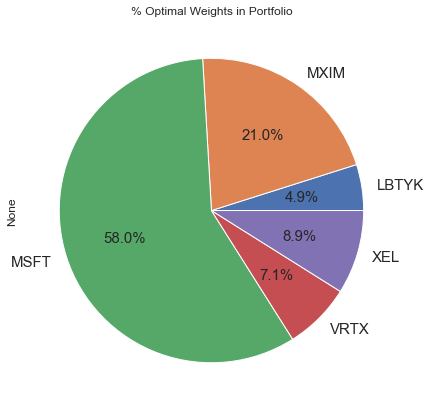

In [41]:
optimal_weights_5.plot(kind='pie',figsize=(7,7),autopct='%1.1f%%',textprops={'fontsize':15})
plt.title("% Optimal Weights in Portfolio");

Should we be worried that so much weight is placed in one company, Microsoft? Yes! We do not believe that the fund should be so heavily tied to the performance of one stock, and if we were going to continue with simply a 5 stock fund, we would likely suggest that we adjust our optimization to also include a constraint that no stock can take up more than 35% of the portfolio.

### Performance Evaluation

We solved the optimization problem, but we would now like to see how the portfolio performs, both out of sample, using 2020 data and looking in sample at 2019. We will evaluate the performance by looking at the returns of our portfolio vs the index.

In [42]:
def calculate_port_returns(weights:pd.Series,returns_df:pd.DataFrame):
    """Send in the weights series and the returns dataframe for the year you are looking at. The function will return a series where the index contains
        the dates, and the values are the return of the portfolio on that day with the specified weights."""

    port_returns = np.dot(returns_df[weights.index].values,weights.values) # Linear algebra saves us a for loop.
    
    return pd.Series(data=port_returns,index=returns_df.index)

port_returns_5 = calculate_port_returns(optimal_weights_5, stock_returns_20)

The primary measure we will use to judge the success of our index replication is:

$$TotalError = \sum_{t=1}^{T} \left\lvert q_t-\sum_{i=1}^{stocks}w_ir_{rt}\right\rvert $$

Where $q_t$ is the return of the index at time $t$ and $\sum_{i=1}^{stocks}w_ir_{rt}$ is the return of our portfolio at time $t$.

<br>

This measure will just give us a sense for how far off our returns were from the index.

In [43]:
def total_error(index_returns:pd.Series, portfolio_returns:pd.Series) -> float:
    """Send in the index returns as a series and the returns of your portfolio and this will return the total error as specified above. """
    return np.abs(index_returns - portfolio_returns).sum()

total_error_5 = total_error(index_returns_20.iloc[:,0],port_returns_5)
print(f'The total error for the five stock fund is: {total_error_5:.4}.')

The total error for the five stock fund is: 1.112.


The above result indicates to us, that if we had invested with these 'optimal' weights, determined using 2019 data, that our portfolio would have had a total error of over 100%. Not ideal!

We also feel that another way to evaluate the performance of the fund is to examine the cumulative return vs the index. This will give us a feel for how the funds moved together over time, and where they ended up at the end of the year. It is possible, that even though the total error is large, as calculated above, the cumulative error could actually be small if our portfolio still resulted in an ending return similar to the index.

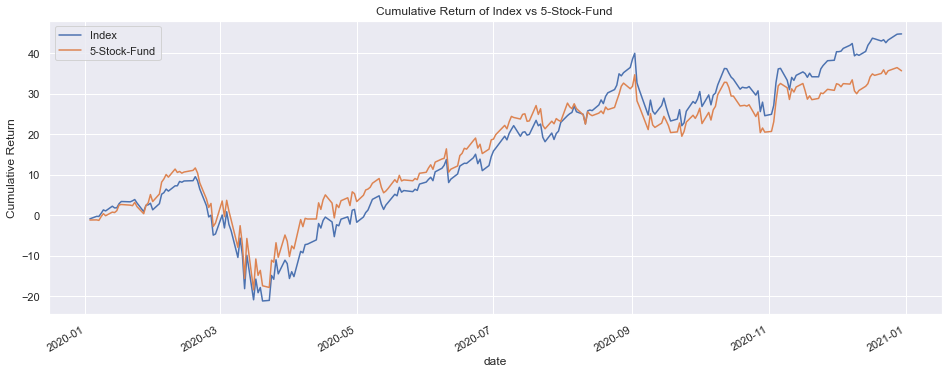

In [44]:
cumualtive_returns_df = index_returns_20.copy()
cumualtive_returns_df['Fund'] = port_returns_5
cumualtive_returns_df = ((cumualtive_returns_df + 1).cumprod() - 1) * 100
cumualtive_returns_df.columns = ['Index','5-Stock-Fund']
cumualtive_returns_df.plot(figsize=(16,6));
plt.title('Cumulative Return of Index vs 5-Stock-Fund ')
plt.ylabel('Cumulative Return');

It looks like the 5-stock-fund does follow the index somewhat, but by the end of the year, the performance diverges substantially, with the index finishing the year with nearly 10% stronger performance. This is clearly an unacceptable deviation from the index return and our clients, who are paying us to track the index, will certainly be displeased.

## Bigger Funds

In an attempt to account for the high divergence between our portfolio and the index, we will now examine the performance of our fund vs the index when we progressively include more and more stocks in the fund.

In [45]:
# Include a bunch of different possible stock numbers in our fund, all the way  up to the entire index. Incremented by 10.
# Store the results in a master dictionary for easy access when we need it later.

possible_stock_nums_in_fund = list(range(10,total_stock_count,10))
if total_stock_count > possible_stock_nums_in_fund[-1]:
    possible_stock_nums_in_fund.append(total_stock_count)

master_optimals_dict = {}

# Create a dataframe to keep track of each fund's total error.
master_errors = pd.DataFrame(columns=['total_error_2019','total_error_2020']) 

for stock_count in possible_stock_nums_in_fund:
    optimals = {}
    if stock_count == total_stock_count:
        # Don't need to optimize if you are doing all of the stocks!
        optimals['tickers'] = list(all_stocks)
    else:
        optimals['tickers'] = find_optimal_stocks(A,b,sense, obj, stock_count)

    # Find the optimal weights.
    optimals['weights_series'] = find_optimal_weights(optimals['tickers'])

    # Calculate both in and out of sample performance
    optimals['returns_19'] = calculate_port_returns(optimals['weights_series'],stock_returns_19)
    optimals['returns_20'] = calculate_port_returns(optimals['weights_series'],stock_returns_20)    
    optimals['total_error_2019'] = total_error(index_returns_19.iloc[:,0],optimals['returns_19'])
    optimals['total_error_2020'] = total_error(index_returns_20.iloc[:,0],optimals['returns_20'])

    master_errors.loc[stock_count] = [optimals['total_error_2019'], optimals['total_error_2020']]

    master_optimals_dict[stock_count] = optimals # Store all this fun info in a master dictionary!
    

Below, we plot the total error as a function of number of stocks in the fund for both 2019 and 2020. Why are they different? It certainly makes sense that the evaluating performance on the 2019 data will look much better, as this is the data we used to find the optimal stocks and weights! But, correlations between stocks are not static, and in fact change over time so it does seem reasonable that our our of sample performance would be worse. 


Is there an optimal amount of stocks to include in each fund? Difficult to say. It depends on how high our transaction costs are and what our investor's tolerance for error. From a cursory glance, it appears that around 30 stocks ahcieves a nice balance between minimizing the error and having as low of transaction cost as possible.

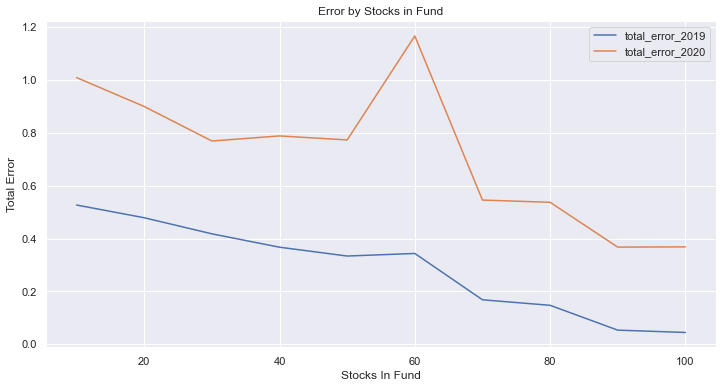

In [46]:
master_errors.plot(figsize=(12,6))
plt.xlabel('Stocks In Fund')
plt.ylabel('Total Error')
plt.title('Error by Stocks in Fund');

#### Cumulatives
Below, we plot a similar relationship as the above plot, but now our performance measurement is the absolute value of the cumulative return difference between our fund and the index.

$$CumulativeError = \left\lvert (\prod_{t=1}^{T}(1+q_t) -1) - (\prod_{t=1}^{T}(1+p_t) -1) \right\rvert * 100$$

where $p_t$ is the return of the portfolio at time $t$.

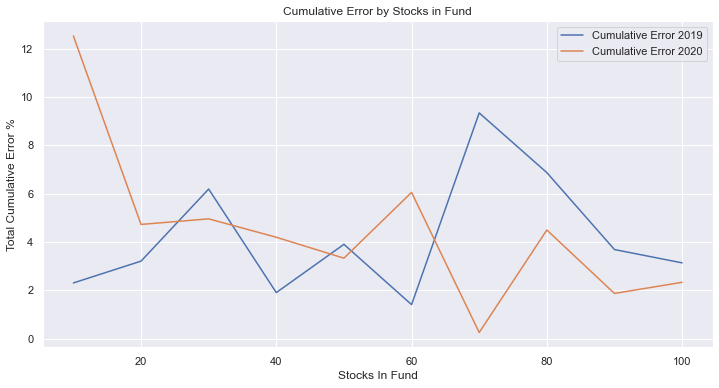

In [47]:
def get_cumulative_returns(returns:pd.Series) -> pd.Series:
    return ((1+returns).cumprod() - 1) * 100

index_cumulatives_20 = get_cumulative_returns(index_returns_20.iloc[:,0])
index_cumulatives_19 = get_cumulative_returns(index_returns_19.iloc[:,0])

cumulative_diffs_19 = []
cumulative_diffs_20 = []

plt.figure(figsize=(12,6))
for stock_count, optimals in master_optimals_dict.items():
    cumulative_returns_19 = get_cumulative_returns(optimals['returns_19'])
    cumulative_diffs_19.append(np.abs(index_cumulatives_19.iloc[-1] - cumulative_returns_19.iloc[-1]))

    cumulative_returns_20 = get_cumulative_returns(optimals['returns_20'])
    cumulative_diffs_20.append(np.abs(index_cumulatives_20.iloc[-1] - cumulative_returns_20.iloc[-1]))

plt.plot(possible_stock_nums_in_fund,cumulative_diffs_19,label='Cumulative Error 2019')
plt.plot(possible_stock_nums_in_fund,cumulative_diffs_20,label='Cumulative Error 2020')
plt.legend();
plt.xlabel('Stocks In Fund')
plt.ylabel('Total Cumulative Error %')
plt.title('Cumulative Error by Stocks in Fund');

The results here are similar to the above, where our greatest reduction in error occurs after about 30 stocks are added to the fund. One interesting note here is that the in sample performance does not look to perform much better than the out of sample, 2020 performance. This likely a consequence of the fact that, our optimization problem was formulated to optimize for $TotalError$ as specified above, not cumulative error. Nevertheless, we still find the cumulative error another helpful metric to explore.

## Method 2: All-In-One Solver

Previously, we split up the optimization into two sequential steps: find the stocks to include in the fund, then finding the optimal weights for each stock in the portfolio. We will now take an alternative approach where we attempt to solve both problems in one go. The constraint matrix we build will be similar to the one we created when finding the weights in method 1, but now we must also add the constraints that will enforce that a stock can only have positive, non zero weight if it is included in the fund. We do this using the typical "big M" constraint. The smallest value of M we can choose is 1 which would represent 100% weight for a stock. This is the minimum value, because we already have another constraint that will force the sum of the weights to be 100%.

In [48]:
num_stocks = 10 

periods_vector = np.ones(periods_2019)
weights_vector = np.zeros(total_stock_count) # This will be set to the optimal weight for the stocks included.
y_vector = np.zeros(total_stock_count) # Indicates if a stock is included or not

obj = np.concatenate([periods_vector,weights_vector,y_vector])
sense = []
v_type = ['C']*(len(periods_vector)+len(weights_vector)) + ['B'] * len(y_vector)
b = []

A = np.zeros(shape=(periods_2019*2 + total_stock_count + 2,len(obj)))


row_counter = 0

for day_index in range(len(stock_returns_19)):
    # Grab that days returns for both stocks and index
    stock_returns = stock_returns_19.iloc[day_index].values 
    index_return = index_returns_19.iloc[day_index,0]

    # Set the two constraint rows for that day. These two constraints help to make our objective function equivalent to the absolute value we want to minimize
    A[row_counter,day_index] = 1
    A[row_counter,periods_2019:(periods_2019+total_stock_count)] = stock_returns # weight coefficients
    b.append(index_return)
    sense.append('>')
    row_counter += 1
    

    A[row_counter,day_index] = 1
    A[row_counter,periods_2019:(periods_2019+total_stock_count)] = -stock_returns
    b.append(-index_return)
    sense.append('>')
    row_counter += 1


# Big M constraint. Force the weight to be 0, if the y variable is 0. This means it can only have a positive weight if the stock is chosen to be in the fund
# The smallest value of M we need is 1 which would represent 100% weight for a stock. This is the minimum value, because we already have another constraint that
# will force the sum of the weights to be 100%.
for i in range(total_stock_count,0,-1):
    A[row_counter,-(i+total_stock_count)] = -1
    A[row_counter,-i] = 1
    b.append(0)
    sense.append('>')
    row_counter += 1


# Constraint that number of stocks needs to be equal to stocks in fund
A[-2,-total_stock_count:] = np.ones(total_stock_count)
sense.append('=')
b.append(num_stocks)


# Constrain that weights sum to one
A[-1,periods_2019:(periods_2019+total_stock_count)] = 1 
sense.append('=')
b.append(1) 


Now we can run the optimization for each fund size.

### WARNING!!
Below cell will take 10 hours to run unless you have changed the 'GUROBI_TIME_LIMIT' variable in the first cell of this notebook.

<br>

First we check to see if there is a file in the current directory named 'optimal_weights.csv'. If there is, we do not need run the otpimization again because we already have the weights and we just read in the optimal weights from the csv.

In [49]:
if os.path.exists('optimal_weights.csv'):
    df_weights = pd.read_csv('optimal_weights.csv',index_col=0)
else:
    # Data frame which will hold the optimal weights for each fund size. 
    df_weights = pd.DataFrame(index=all_stocks)

    for stock_num in possible_stock_nums_in_fund:
        # The only thing changing in each loop is the amount of stocks we allow in the fund.
        b_adjusted = b.copy()
        b_adjusted[-2] = stock_num

        # Now run gurobi model for each stock number
        model = gp.Model()
        mod_x = model.addMVar(len(obj),vtype=v_type)
        mod_con = model.addMConstr(A, mod_x, sense, b_adjusted)
        model.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)
        model.Params.OutputFlag = 0 # tell gurobi to shut up!!
        model.Params.TimeLimit = GUROBI_TIME_LIMIT
        model.optimize()

        weights = mod_x.x[periods_2019:(periods_2019+total_stock_count)]
        df_weights[stock_num] = weights
        df_weights.to_csv('optimal_weights.csv') # Save after each run, just in case we bug out somewhere!!

df_weights.head()

,10,20,30,40,50,60,70,80,90,100
ATVI,0.00000,0.00000,0.00999,0.00000,0.00000,0.00308,0.00349,0.00312,0.00422,0.00422
ADBE,0.00000,0.00000,0.01966,0.02474,0.02387,0.01881,0.01827,0.01784,0.01714,0.01714
AMD,0.00000,0.00000,0.00000,0.00603,0.00000,0.00348,0.00377,0.00357,0.00404,0.00404
ALXN,0.00000,0.00000,0.00000,0.00000,0.00271,0.00000,0.00000,0.00127,0.00245,0.00245
ALGN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


Grab, the relevant performance metrics for this method:

In [50]:
total_errors = pd.DataFrame(columns=['total_error_2019','total_error_2020']) 
total_cum_diffs = pd.DataFrame(columns=['Cumulative Error 2019','Cumulative Error 2020']) 

for col_name in df_weights:
    returns_19 = calculate_port_returns(df_weights[col_name], stock_returns_19)
    returns_20 = calculate_port_returns(df_weights[col_name], stock_returns_20)

    total_errors.loc[col_name] = [total_error(index_returns_19.iloc[:,0], returns_19), total_error(index_returns_20.iloc[:,0],returns_20)]

    total_cum_diffs.loc[col_name] = [np.abs(index_cumulatives_19.iloc[-1] - get_cumulative_returns(returns_19).iloc[-1]), np.abs(index_cumulatives_20.iloc[-1] - get_cumulative_returns(returns_20).iloc[-1])]
    

The total error for this method is plotted, just as before. The biggest contrast that jumps out, is the smoothness of these decreases, compared with last time. This consistency gives us a bit more confidence in this method. On top of that, it looks as if we reach our plateau of errors much quicker.

Again, we see that after reaching around 30 or so stocks the erros flatten out and we only achieve small marginal benefits. 

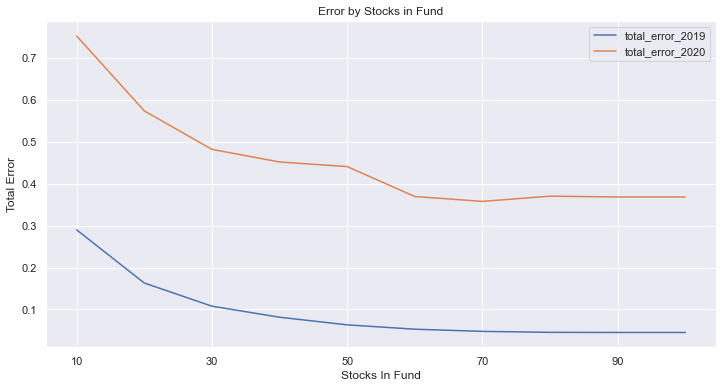

In [51]:
total_errors.plot(figsize=(12,6))
plt.xlabel('Stocks In Fund')
plt.ylabel('Total Error')
plt.title('Error by Stocks in Fund');

This chart looks as if it tells the same story: errors flattening out after 30 stocks.

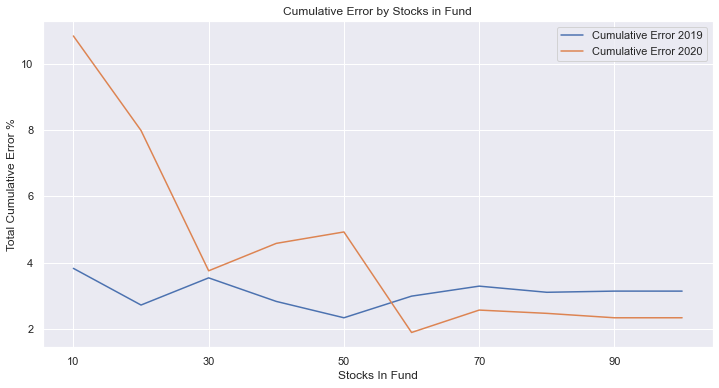

In [52]:
total_cum_diffs.plot(figsize=(12,6))
plt.xlabel('Stocks In Fund')
plt.ylabel('Total Cumulative Error %')
plt.title('Cumulative Error by Stocks in Fund');

## Conclusion:

We feel that the most appropriate recommendation we can make is for the fund to choose methodology two, All-In-One and include 30-40 stocks in the portfolio. We notice that at this size, we wil already achieve most of the error minimization benefits we can get, and we can still keep transaction costs relatively low. We also suggest that the fund re-calculate the optimal weights to use at the end of each month, where new data can be included. This will keep the optimal weights fresh and ensure the fund adapts to changing market conditions. 